from https://keras.io/examples/generative/wgan_gp/

# 데이터 준비

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Input, Reshape
from tensorflow.keras.layers import LeakyReLU, Activation
from tensorflow.keras.layers import Cropping2D, ZeroPadding2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback

In [2]:
IMG_SHAPE = (32, 32, 3)
BATCH_SIZE = 512

noise_dim = 128

dataset = keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5

Number of examples: 50000
Shape of the images in the dataset: (32, 32, 3)


# D 정의

In [3]:
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = Input(shape=IMG_SHAPE)
    x = img_input
    x = conv_block(x,  64, (5, 5), use_dropout=False)
    x = conv_block(x, 128, (5, 5), use_dropout=True)
    x = conv_block(x, 256, (5, 5), use_dropout=True)
    x = conv_block(x, 512, (5, 5), use_dropout=False)
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   4864        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        multiple             0           ['conv2d[0][0]',                 
                                                                  'conv2d_1[0][0]',               
                                                                  'conv2d_2[0][0]',               
                                                                  'conv2d_3[0][0]']   

# G 정의


In [4]:

def upsample_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    activation = LeakyReLU(0.2),
    use_bn=True,
    use_bias=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = Input(shape=(noise_dim,))
    x = Dense(4 * 4 * 256, use_bias=False)(noise)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Reshape((4, 4, 256))(x)
    x = upsample_block(x, 128, )
    x = upsample_block(x,  64, )
    x = upsample_block(x,   3, activation=Activation("tanh"))

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 4096)         524288      ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 4096)        16384       ['dense_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 leaky_re_lu_2 (LeakyReLU)      (None, 4096)         0           ['batch_normalization[0][

# WGAN-GP 모델 정의

In [5]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        # D 학습

        # D는 G에 비해 d_steps 배 학습함.
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)
                real_logits = self.discriminator(real_images, training=True)

                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                d_loss = d_cost + gp * self.gp_weight

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

        # G 학습
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss_fn(gen_img_logits)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}

# 에폭 마다 결과 보는 callback

In [6]:
import matplotlib.pyplot as plt

class GANMonitor(Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        print("epoch",epoch)
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 0.5) + 0.5
        generated_images = np.clip(generated_images.numpy(), 0.0, 1.1)

        plt.figure(figsize=(10, 3))
        for i in range(1, self.num_img):
            ax = plt.subplot(1, self.num_img, i)
            plt.imshow(generated_images[i-1].squeeze(), cmap="binary")
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

        # for i in range(self.num_img):
        #     img = generated_images[i].numpy()
        #     img = keras.preprocessing.image.array_to_img(img)
        #     img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))



# 학습


Epoch 1/100
98/98 [==============================] - ETA: 0s - d_loss: -6.8488 - g_loss: 22.6487epoch 0


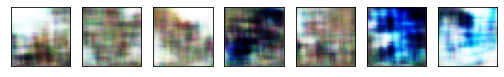

98/98 [==============================] - 45s 331ms/step - d_loss: -6.8153 - g_loss: 22.5046
Epoch 2/100
98/98 [==============================] - ETA: 0s - d_loss: -3.8043 - g_loss: 11.3446epoch 1


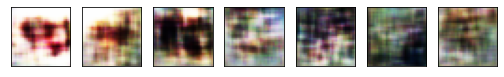

98/98 [==============================] - 32s 328ms/step - d_loss: -3.8090 - g_loss: 11.3671
Epoch 3/100
98/98 [==============================] - ETA: 0s - d_loss: -3.4398 - g_loss: 8.9475epoch 2


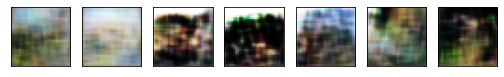

98/98 [==============================] - 33s 332ms/step - d_loss: -3.4374 - g_loss: 9.0141
Epoch 4/100
98/98 [==============================] - ETA: 0s - d_loss: -3.4001 - g_loss: 3.4816epoch 3


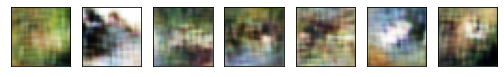

98/98 [==============================] - 32s 330ms/step - d_loss: -3.4012 - g_loss: 3.4427
Epoch 5/100
98/98 [==============================] - ETA: 0s - d_loss: -3.0266 - g_loss: 2.0010epoch 4


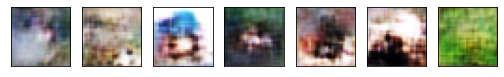

98/98 [==============================] - 32s 330ms/step - d_loss: -3.0244 - g_loss: 2.0294
Epoch 6/100
98/98 [==============================] - ETA: 0s - d_loss: -2.8023 - g_loss: 2.1777epoch 5


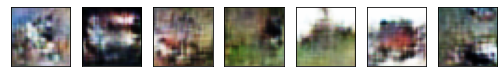

98/98 [==============================] - 32s 330ms/step - d_loss: -2.8042 - g_loss: 2.2029
Epoch 7/100
98/98 [==============================] - ETA: 0s - d_loss: -2.7707 - g_loss: 3.8000epoch 6


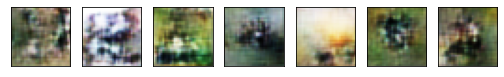

98/98 [==============================] - 33s 333ms/step - d_loss: -2.7637 - g_loss: 3.8356
Epoch 8/100
98/98 [==============================] - ETA: 0s - d_loss: -2.7496 - g_loss: 5.4510epoch 7


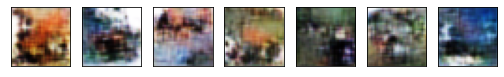

98/98 [==============================] - 32s 331ms/step - d_loss: -2.7498 - g_loss: 5.2915
Epoch 9/100
98/98 [==============================] - ETA: 0s - d_loss: -2.7284 - g_loss: 1.4444epoch 8


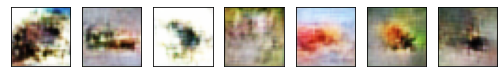

98/98 [==============================] - 32s 330ms/step - d_loss: -2.7276 - g_loss: 1.4705
Epoch 10/100
98/98 [==============================] - ETA: 0s - d_loss: -2.5862 - g_loss: -1.8971epoch 9


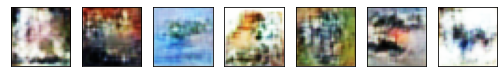

98/98 [==============================] - 32s 331ms/step - d_loss: -2.5954 - g_loss: -1.8523
Epoch 11/100
98/98 [==============================] - ETA: 0s - d_loss: -2.5335 - g_loss: -2.6733epoch 10


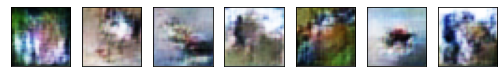

98/98 [==============================] - 32s 330ms/step - d_loss: -2.5235 - g_loss: -2.7312
Epoch 12/100
98/98 [==============================] - ETA: 0s - d_loss: -2.3510 - g_loss: -0.6245epoch 11


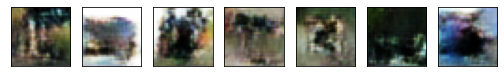

98/98 [==============================] - 32s 331ms/step - d_loss: -2.3317 - g_loss: -0.5220
Epoch 13/100
98/98 [==============================] - ETA: 0s - d_loss: -2.2676 - g_loss: 0.1568epoch 12


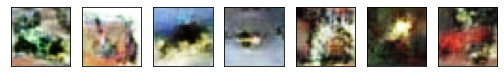

98/98 [==============================] - 32s 330ms/step - d_loss: -2.2665 - g_loss: 0.2096
Epoch 14/100
98/98 [==============================] - ETA: 0s - d_loss: -2.1437 - g_loss: 0.2181epoch 13


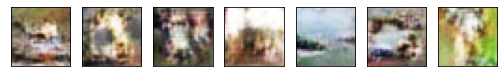

98/98 [==============================] - 33s 333ms/step - d_loss: -2.1427 - g_loss: 0.2287
Epoch 15/100
98/98 [==============================] - ETA: 0s - d_loss: -2.1320 - g_loss: 1.1259epoch 14


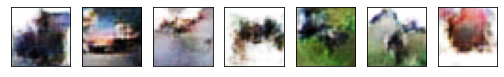

98/98 [==============================] - 33s 332ms/step - d_loss: -2.1377 - g_loss: 1.1098
Epoch 16/100
98/98 [==============================] - ETA: 0s - d_loss: -2.1365 - g_loss: -0.3925epoch 15


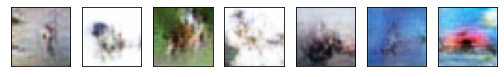

98/98 [==============================] - 32s 331ms/step - d_loss: -2.1355 - g_loss: -0.3693
Epoch 17/100
98/98 [==============================] - ETA: 0s - d_loss: -2.2379 - g_loss: -2.4541epoch 16


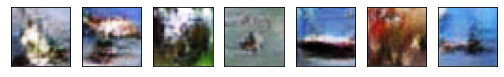

98/98 [==============================] - 33s 332ms/step - d_loss: -2.2304 - g_loss: -2.5661
Epoch 18/100
98/98 [==============================] - ETA: 0s - d_loss: -1.9653 - g_loss: 0.2459epoch 17


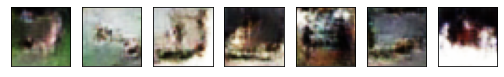

98/98 [==============================] - 33s 332ms/step - d_loss: -1.9675 - g_loss: 0.2610
Epoch 19/100
98/98 [==============================] - ETA: 0s - d_loss: -1.9088 - g_loss: 1.3758epoch 18


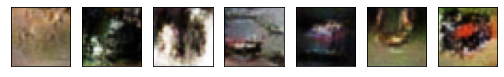

98/98 [==============================] - 32s 331ms/step - d_loss: -1.9145 - g_loss: 1.4070
Epoch 20/100
98/98 [==============================] - ETA: 0s - d_loss: -1.8993 - g_loss: 5.0177epoch 19


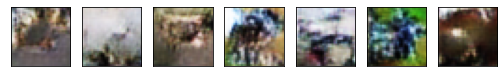

98/98 [==============================] - 33s 332ms/step - d_loss: -1.9087 - g_loss: 5.0543
Epoch 21/100
98/98 [==============================] - ETA: 0s - d_loss: -1.8155 - g_loss: 2.9581epoch 20


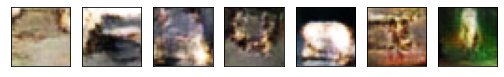

98/98 [==============================] - 32s 331ms/step - d_loss: -1.8070 - g_loss: 2.8976
Epoch 22/100
98/98 [==============================] - ETA: 0s - d_loss: -1.8420 - g_loss: -2.1612epoch 21


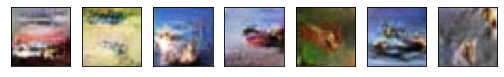

98/98 [==============================] - 33s 335ms/step - d_loss: -1.8278 - g_loss: -2.1828
Epoch 23/100
98/98 [==============================] - ETA: 0s - d_loss: -1.8344 - g_loss: 1.6308epoch 22


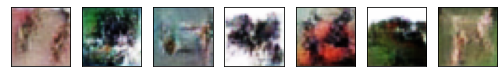

98/98 [==============================] - 33s 332ms/step - d_loss: -1.8318 - g_loss: 1.4948
Epoch 24/100
98/98 [==============================] - ETA: 0s - d_loss: -1.8243 - g_loss: -4.8772epoch 23


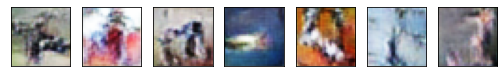

98/98 [==============================] - 33s 333ms/step - d_loss: -1.8046 - g_loss: -4.8633
Epoch 25/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6402 - g_loss: 2.3212epoch 24


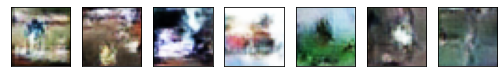

98/98 [==============================] - 32s 331ms/step - d_loss: -1.6484 - g_loss: 2.5237
Epoch 26/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7142 - g_loss: 1.6341epoch 25


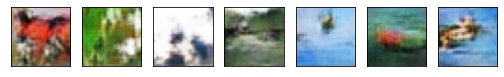

98/98 [==============================] - 33s 333ms/step - d_loss: -1.7072 - g_loss: 1.6479
Epoch 27/100
98/98 [==============================] - ETA: 0s - d_loss: -1.7640 - g_loss: 5.5526epoch 26


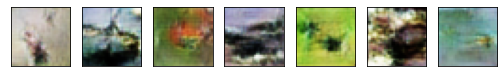

98/98 [==============================] - 33s 333ms/step - d_loss: -1.7569 - g_loss: 5.4378
Epoch 28/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4855 - g_loss: -6.7520epoch 27


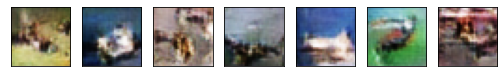

98/98 [==============================] - 33s 334ms/step - d_loss: -1.4730 - g_loss: -6.6703
Epoch 29/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6089 - g_loss: -4.7133epoch 28


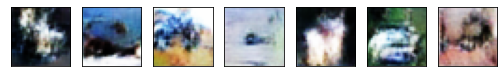

98/98 [==============================] - 33s 335ms/step - d_loss: -1.6184 - g_loss: -4.6709
Epoch 30/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5451 - g_loss: 3.4481epoch 29


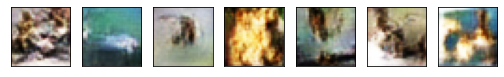

98/98 [==============================] - 33s 333ms/step - d_loss: -1.5530 - g_loss: 3.5223
Epoch 31/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5373 - g_loss: -1.7112epoch 30


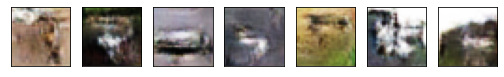

98/98 [==============================] - 33s 333ms/step - d_loss: -1.5134 - g_loss: -1.6837
Epoch 32/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5560 - g_loss: 1.1062epoch 31


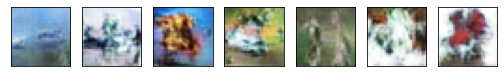

98/98 [==============================] - 33s 333ms/step - d_loss: -1.5512 - g_loss: 1.1120
Epoch 33/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5976 - g_loss: 1.4683epoch 32


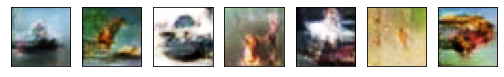

98/98 [==============================] - 33s 332ms/step - d_loss: -1.5983 - g_loss: 1.4925
Epoch 34/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4625 - g_loss: 1.1925epoch 33


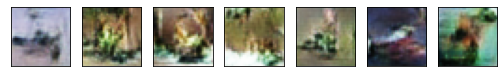

98/98 [==============================] - 33s 333ms/step - d_loss: -1.4720 - g_loss: 1.2106
Epoch 35/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6316 - g_loss: 3.0102epoch 34


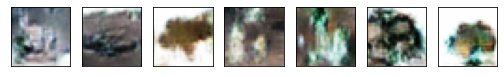

98/98 [==============================] - 33s 333ms/step - d_loss: -1.6334 - g_loss: 2.9814
Epoch 36/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6465 - g_loss: 1.3152epoch 35


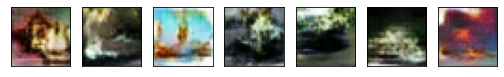

98/98 [==============================] - 33s 333ms/step - d_loss: -1.6586 - g_loss: 1.1074
Epoch 37/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4832 - g_loss: -0.3628epoch 36


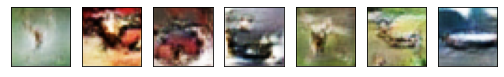

98/98 [==============================] - 33s 335ms/step - d_loss: -1.4633 - g_loss: -0.3851
Epoch 38/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6626 - g_loss: 0.2668epoch 37


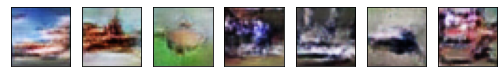

98/98 [==============================] - 33s 333ms/step - d_loss: -1.6586 - g_loss: 0.2037
Epoch 39/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6303 - g_loss: 1.6863epoch 38


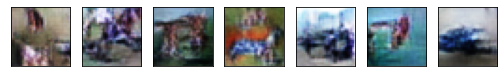

98/98 [==============================] - 33s 333ms/step - d_loss: -1.6363 - g_loss: 1.6918
Epoch 40/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6559 - g_loss: -0.3664epoch 39


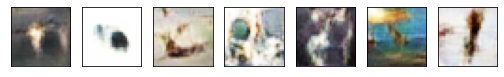

98/98 [==============================] - 33s 333ms/step - d_loss: -1.6680 - g_loss: -0.2583
Epoch 41/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6481 - g_loss: 1.4334epoch 40


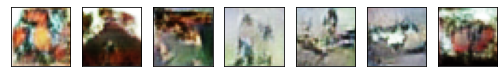

98/98 [==============================] - 32s 331ms/step - d_loss: -1.6458 - g_loss: 1.5071
Epoch 42/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5647 - g_loss: 3.6260epoch 41


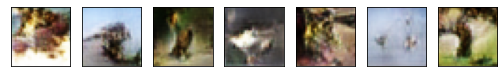

98/98 [==============================] - 33s 333ms/step - d_loss: -1.5760 - g_loss: 3.5490
Epoch 43/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6141 - g_loss: -2.9125epoch 42


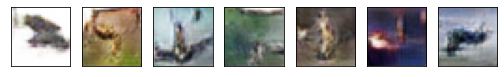

98/98 [==============================] - 33s 333ms/step - d_loss: -1.6293 - g_loss: -2.9128
Epoch 44/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5462 - g_loss: -1.2008epoch 43


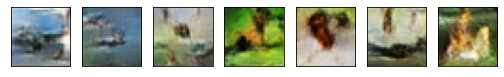

98/98 [==============================] - 33s 334ms/step - d_loss: -1.5241 - g_loss: -1.2846
Epoch 45/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5807 - g_loss: 1.6324epoch 44


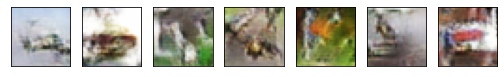

98/98 [==============================] - 33s 332ms/step - d_loss: -1.5955 - g_loss: 1.6563
Epoch 46/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4028 - g_loss: 1.3366epoch 45


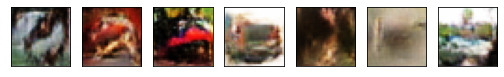

98/98 [==============================] - 33s 332ms/step - d_loss: -1.3955 - g_loss: 1.3108
Epoch 47/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4431 - g_loss: -0.6694epoch 46


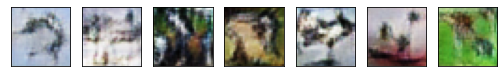

98/98 [==============================] - 33s 333ms/step - d_loss: -1.4548 - g_loss: -0.6841
Epoch 48/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3763 - g_loss: 5.0636epoch 47


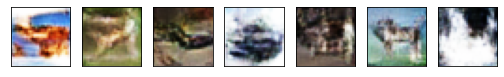

98/98 [==============================] - 33s 333ms/step - d_loss: -1.3754 - g_loss: 5.0989
Epoch 49/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4234 - g_loss: -0.4651epoch 48


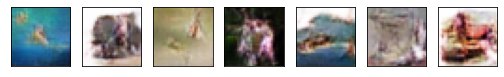

98/98 [==============================] - 33s 333ms/step - d_loss: -1.4130 - g_loss: -0.4753
Epoch 50/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5640 - g_loss: -1.2283epoch 49


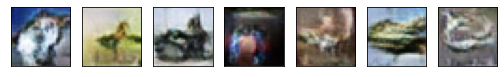

98/98 [==============================] - 33s 333ms/step - d_loss: -1.5710 - g_loss: -1.2439
Epoch 51/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5066 - g_loss: 2.1426epoch 50


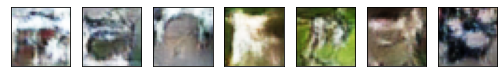

98/98 [==============================] - 33s 333ms/step - d_loss: -1.5160 - g_loss: 2.1158
Epoch 52/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3947 - g_loss: 2.2684epoch 51


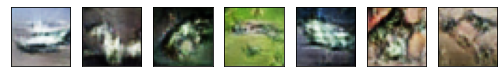

98/98 [==============================] - 33s 336ms/step - d_loss: -1.3909 - g_loss: 2.3221
Epoch 53/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4692 - g_loss: 0.6936epoch 52


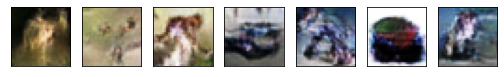

98/98 [==============================] - 33s 333ms/step - d_loss: -1.4669 - g_loss: 0.7115
Epoch 54/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5754 - g_loss: -2.9885epoch 53


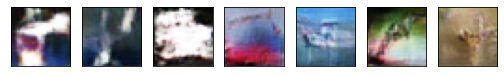

98/98 [==============================] - 33s 332ms/step - d_loss: -1.5773 - g_loss: -2.9887
Epoch 55/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2737 - g_loss: 1.5861epoch 54


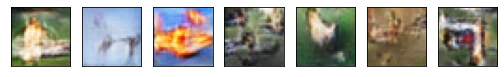

98/98 [==============================] - 33s 333ms/step - d_loss: -1.2750 - g_loss: 1.5374
Epoch 56/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2737 - g_loss: 2.5045epoch 55


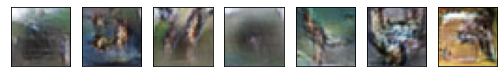

98/98 [==============================] - 33s 333ms/step - d_loss: -1.2823 - g_loss: 2.5133
Epoch 57/100
98/98 [==============================] - ETA: 0s - d_loss: -1.5064 - g_loss: -0.2959epoch 56


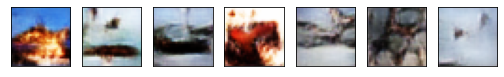

98/98 [==============================] - 33s 333ms/step - d_loss: -1.4983 - g_loss: -0.3871
Epoch 58/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4239 - g_loss: -4.3832epoch 57


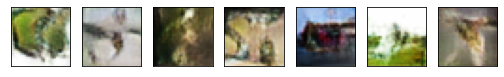

98/98 [==============================] - 33s 333ms/step - d_loss: -1.4246 - g_loss: -4.2874
Epoch 59/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6425 - g_loss: 2.6225epoch 58


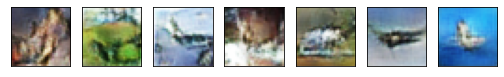

98/98 [==============================] - 33s 335ms/step - d_loss: -1.6382 - g_loss: 2.5993
Epoch 60/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4883 - g_loss: -0.7385epoch 59


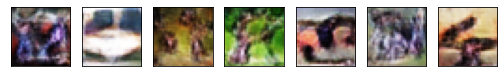

98/98 [==============================] - 33s 333ms/step - d_loss: -1.5044 - g_loss: -0.8055
Epoch 61/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3736 - g_loss: 1.8828epoch 60


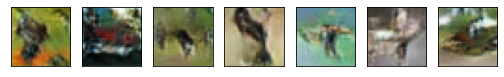

98/98 [==============================] - 33s 333ms/step - d_loss: -1.3611 - g_loss: 1.9058
Epoch 62/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4347 - g_loss: -2.5930epoch 61


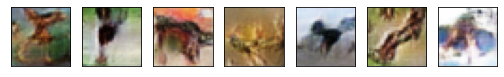

98/98 [==============================] - 33s 334ms/step - d_loss: -1.4400 - g_loss: -2.6236
Epoch 63/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4481 - g_loss: -4.2251epoch 62


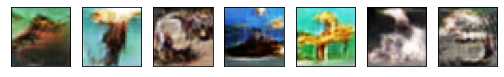

98/98 [==============================] - 33s 333ms/step - d_loss: -1.4189 - g_loss: -4.2311
Epoch 64/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3489 - g_loss: 2.4321epoch 63


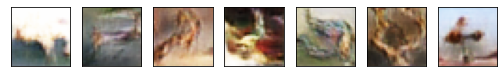

98/98 [==============================] - 33s 334ms/step - d_loss: -1.3392 - g_loss: 2.4920
Epoch 65/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4971 - g_loss: 4.3369epoch 64


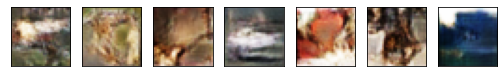

98/98 [==============================] - 33s 333ms/step - d_loss: -1.5005 - g_loss: 4.3662
Epoch 66/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4139 - g_loss: 3.7933epoch 65


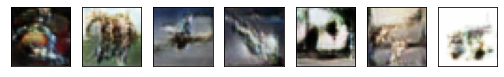

98/98 [==============================] - 33s 333ms/step - d_loss: -1.4408 - g_loss: 3.7912
Epoch 67/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3391 - g_loss: 3.2117epoch 66


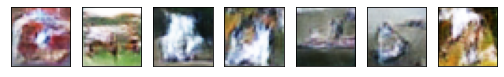

98/98 [==============================] - 33s 335ms/step - d_loss: -1.3353 - g_loss: 3.1142
Epoch 68/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2109 - g_loss: 1.8107epoch 67


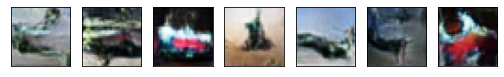

98/98 [==============================] - 33s 333ms/step - d_loss: -1.2255 - g_loss: 1.8610
Epoch 69/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1099 - g_loss: 0.1998epoch 68


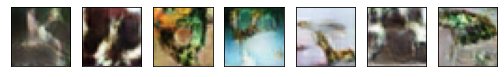

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1175 - g_loss: 0.1825
Epoch 70/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2709 - g_loss: 3.4068epoch 69


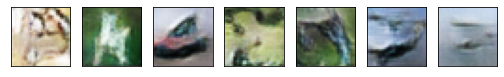

98/98 [==============================] - 33s 333ms/step - d_loss: -1.2629 - g_loss: 3.4391
Epoch 71/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2389 - g_loss: 1.7470epoch 70


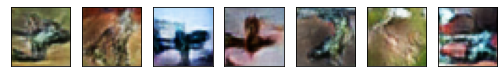

98/98 [==============================] - 33s 334ms/step - d_loss: -1.2302 - g_loss: 1.6249
Epoch 72/100
98/98 [==============================] - ETA: 0s - d_loss: -1.3936 - g_loss: -2.3919epoch 71


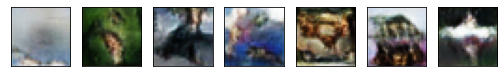

98/98 [==============================] - 33s 332ms/step - d_loss: -1.4020 - g_loss: -2.4084
Epoch 73/100
98/98 [==============================] - ETA: 0s - d_loss: -1.4469 - g_loss: -4.6890epoch 72


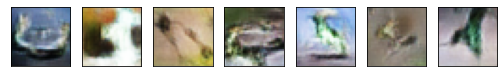

98/98 [==============================] - 33s 333ms/step - d_loss: -1.4641 - g_loss: -4.5330
Epoch 74/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2025 - g_loss: -1.8862epoch 73


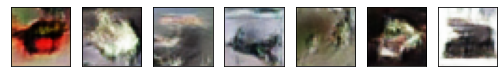

98/98 [==============================] - 33s 335ms/step - d_loss: -1.2036 - g_loss: -1.9875
Epoch 75/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6711 - g_loss: 0.7275epoch 74


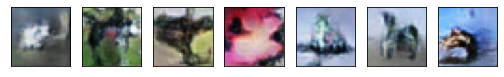

98/98 [==============================] - 33s 332ms/step - d_loss: -1.6706 - g_loss: 0.8058
Epoch 76/100
98/98 [==============================] - ETA: 0s - d_loss: -1.6233 - g_loss: 0.1853epoch 75


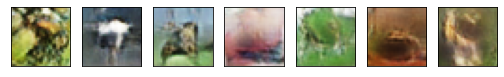

98/98 [==============================] - 33s 333ms/step - d_loss: -1.6480 - g_loss: 0.0407
Epoch 77/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1384 - g_loss: 3.1054epoch 76


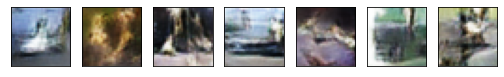

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1611 - g_loss: 3.2374
Epoch 78/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2907 - g_loss: -2.8562epoch 77


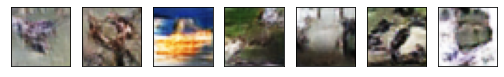

98/98 [==============================] - 33s 333ms/step - d_loss: -1.2864 - g_loss: -2.7322
Epoch 79/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2084 - g_loss: 1.3661epoch 78


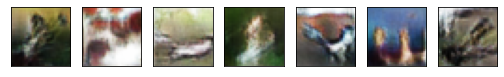

98/98 [==============================] - 33s 333ms/step - d_loss: -1.2084 - g_loss: 1.4363
Epoch 80/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2490 - g_loss: 10.4377epoch 79


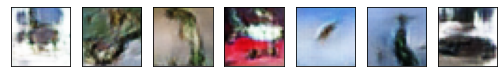

98/98 [==============================] - 33s 333ms/step - d_loss: -1.2536 - g_loss: 10.3699
Epoch 81/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2757 - g_loss: -2.1528epoch 80


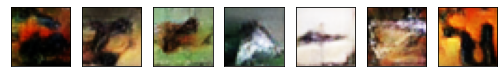

98/98 [==============================] - 33s 333ms/step - d_loss: -1.2957 - g_loss: -2.0955
Epoch 82/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1850 - g_loss: 2.7156epoch 81


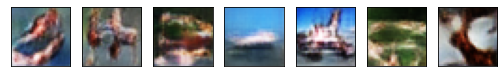

98/98 [==============================] - 33s 334ms/step - d_loss: -1.1882 - g_loss: 2.6983
Epoch 83/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1077 - g_loss: -3.4765epoch 82


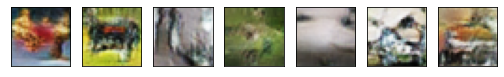

98/98 [==============================] - 33s 332ms/step - d_loss: -1.0943 - g_loss: -3.4434
Epoch 84/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1544 - g_loss: 6.2177epoch 83


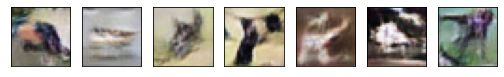

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1770 - g_loss: 6.1446
Epoch 85/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2458 - g_loss: -2.5665epoch 84


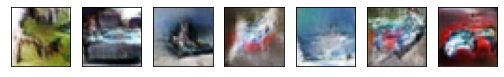

98/98 [==============================] - 33s 333ms/step - d_loss: -1.2148 - g_loss: -2.4844
Epoch 86/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1473 - g_loss: 0.2692epoch 85


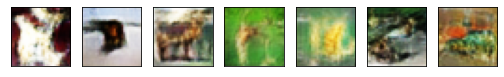

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1609 - g_loss: 0.1758
Epoch 87/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1376 - g_loss: -3.9393epoch 86


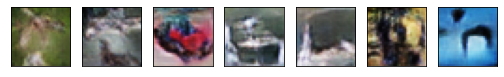

98/98 [==============================] - 33s 332ms/step - d_loss: -1.1437 - g_loss: -3.9258
Epoch 88/100
98/98 [==============================] - ETA: 0s - d_loss: -1.0045 - g_loss: -0.2769epoch 87


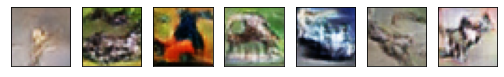

98/98 [==============================] - 33s 333ms/step - d_loss: -1.0167 - g_loss: -0.3317
Epoch 89/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1663 - g_loss: -0.2368epoch 88


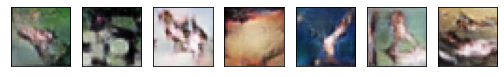

98/98 [==============================] - 33s 336ms/step - d_loss: -1.1581 - g_loss: -0.2206
Epoch 90/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1428 - g_loss: -0.0841epoch 89


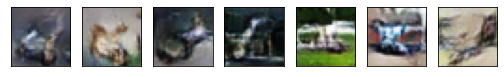

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1533 - g_loss: -0.0695
Epoch 91/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1187 - g_loss: 0.4886epoch 90


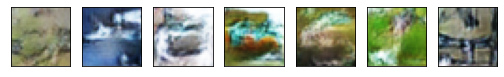

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1107 - g_loss: 0.5212
Epoch 92/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1890 - g_loss: 4.1101epoch 91


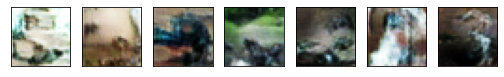

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1868 - g_loss: 4.0825
Epoch 93/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1576 - g_loss: 2.8851epoch 92


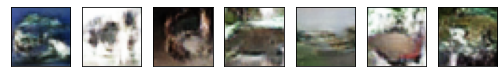

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1597 - g_loss: 2.8427
Epoch 94/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1829 - g_loss: 1.5966epoch 93


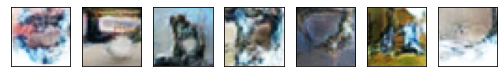

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1905 - g_loss: 1.5527
Epoch 95/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2013 - g_loss: 1.1476epoch 94


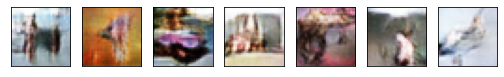

98/98 [==============================] - 33s 333ms/step - d_loss: -1.2063 - g_loss: 1.1712
Epoch 96/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1240 - g_loss: 2.1034epoch 95


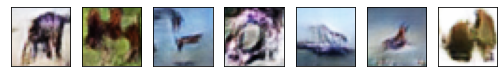

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1260 - g_loss: 2.1687
Epoch 97/100
98/98 [==============================] - ETA: 0s - d_loss: -1.2226 - g_loss: 3.7171epoch 96


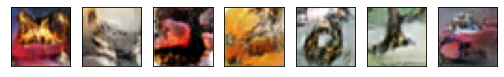

98/98 [==============================] - 33s 334ms/step - d_loss: -1.2202 - g_loss: 3.7157
Epoch 98/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1390 - g_loss: 1.3707epoch 97


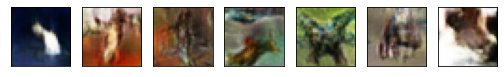

98/98 [==============================] - 33s 334ms/step - d_loss: -1.1487 - g_loss: 1.3766
Epoch 99/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1340 - g_loss: 0.2577epoch 98


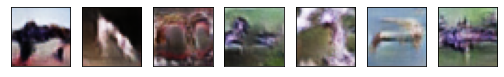

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1448 - g_loss: 0.2926
Epoch 100/100
98/98 [==============================] - ETA: 0s - d_loss: -1.1742 - g_loss: 2.1484epoch 99


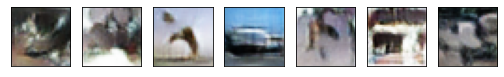

98/98 [==============================] - 33s 333ms/step - d_loss: -1.1705 - g_loss: 2.0659


In [7]:
generator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

cbk = GANMonitor(num_img=8, latent_dim=noise_dim)
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=100, callbacks=[cbk])

Display the last generated images:


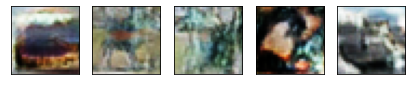

In [8]:
import matplotlib.pyplot as plt

random_latent_vectors = tf.random.normal(shape=(6, noise_dim))

generated_images = wgan.generator(random_latent_vectors)
generated_images = (generated_images * 0.5) + 0.5
generated_images = np.clip(generated_images.numpy(), 0.0, 1.0)

plt.figure(figsize=(10, 3))
for i in range(1,6):
    ax = plt.subplot(1, 7, i)
    plt.imshow(generated_images[i-1].squeeze(), cmap="binary")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
